In [111]:
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [112]:
class person:
    def __init__(
        self,
        name,
        amt_prod_food_per_day, 
        amt_prod_cloth_per_day,
        px_1_food_in_cloth
    ):  
        '''
        Parameters
        ----------
        px_1_food_in_cloth: Amount of cloth equal to one food
        '''
        self.name = name
        
        self.amt_food = 10
        self.amt_cloth = 10
        
        self.amt_cons_food_per_day = 2
        self.amt_cons_cloth_per_day = 2
        
        self.amt_prod_food_per_day = amt_prod_food_per_day
        self.amt_prod_cloth_per_day = amt_prod_cloth_per_day
        
        self.px_1_food_in_cloth = px_1_food_in_cloth
        
        self.log = ''

    
    
    def consume(self):
        if self.amt_food >= self.amt_cons_food_per_day:
            self.amt_food = self.amt_food - self.amt_cons_food_per_day
        else:
            raise Exception('No food to consume')
        
        if self.amt_cloth >= self.amt_cons_cloth_per_day:
            self.amt_cloth = self.amt_cloth - self.amt_cons_cloth_per_day
        else:
            raise Exception('No cloth to consume')
    
    def produce_food(self):
        self.amt_food = self.amt_food + self.amt_prod_food_per_day

    def produce_cloth(self):
        self.amt_cloth = self.amt_cloth + self.amt_prod_cloth_per_day
        
    def buy_food(self, seller):
        if seller.amt_food > 1:         
            if self.amt_cloth > 1 * self.px_1_food_in_cloth:
                self.amt_cloth = self.amt_cloth - 1 * self.px_1_food_in_cloth
                seller.amt_cloth = seller.amt_cloth + 1 * self.px_1_food_in_cloth
                
                self.amt_food = self.amt_food + 1
                seller.amt_food = seller.amt_food - 1
                print(self.name + ' bought 1 food')
        else:
            print('No food bought')

    def buy_cloth(self, seller):
        # pdb.set_trace()
        if seller.amt_cloth > 1:
            if self.amt_food > 1.0 / self.px_1_food_in_cloth:
                self.amt_food = self.amt_food - 1.0 / self.px_1_food_in_cloth
                seller.amt_food = seller.amt_food + 1.0 / self.px_1_food_in_cloth
                
                self.amt_cloth = self.amt_cloth + 1
                seller.amt_cloth = seller.amt_cloth - 1
                print(self.name + ' bought 1 cloth')
        else:
            print('No cloth bought')

In [113]:
class economy:
    
    PX_1_FOOD_IN_CLOTH = 1
    
    def __init__(
        self,
        run_days = np.arange(0, 20, step=1)
    ):
        '''
        Parameters
        ----------
        run_days: int
            Number of days to run the economy.
        '''
        self.run_days = run_days
        
        # Define persons in economy
        self.farmer = person(
            name = 'farmer',
            amt_prod_food_per_day = 5, 
            amt_prod_cloth_per_day = 1,
            px_1_food_in_cloth = economy.PX_1_FOOD_IN_CLOTH
        )

        self.carpenter = person(
            name = 'carpenter',
            amt_prod_food_per_day = 1, 
            amt_prod_cloth_per_day = 5,
            px_1_food_in_cloth = economy.PX_1_FOOD_IN_CLOTH
        )
        
    def display_amounts(self):
        print(f"Farmer: Food: {self.farmer.amt_food}, Cloth: {self.farmer.amt_cloth}")
        print(f"Carpenter: Food: {self.carpenter.amt_food}, Cloth: {self.carpenter.amt_cloth}")
    
    
    def run_economy(self):
        tot_amt_farmer = {}
        tot_amt_carpenter = {}
        for i in self.run_days:
            print('Day ' + str(i) + ' starts')
            
            self.display_amounts()
            
            # Produce
            print(f'******\nProducing...')
            self.farmer.produce_food()
            self.carpenter.produce_cloth()
            print(f'Produce done')
            
            self.display_amounts()
            
            # Trade
            print(f'******\nTrading...')
            while self.farmer.amt_cloth <= 2:
                self.farmer.buy_cloth(self.carpenter)

            while self.carpenter.amt_food <= 2:
                self.carpenter.buy_food(self.farmer)
            print(f'Trade done')
            
            self.display_amounts()
            
            # Consume
            print(f'******\nConsuming...')
            self.farmer.consume()
            self.carpenter.consume()
            print(f'Consume done')
            
            self.display_amounts()
                
            tot_amt_farmer[i] = {'food': self.farmer.amt_food, 'cloth': self.farmer.amt_cloth}
            tot_amt_carpenter[i] = {'food': self.carpenter.amt_food, 'cloth': self.carpenter.amt_cloth}

            print('Day ' + str(i) + ' ends')
            print('-------------------------')
        
        # total wealth per person
        df_tot_amt_farmer = pd.DataFrame.from_dict(tot_amt_farmer, orient='index')
        df_tot_amt_carpenter = pd.DataFrame.from_dict(tot_amt_carpenter, orient='index')
        
        # total wealth of economy
        tot_wealth = ( 
            df_tot_amt_farmer['food'] + df_tot_amt_farmer['cloth'] / economy.PX_1_FOOD_IN_CLOTH +
            df_tot_amt_carpenter['food'] + df_tot_amt_carpenter['cloth'] / economy.PX_1_FOOD_IN_CLOTH
        )
        
        self.farmer.df_tot_amt = df_tot_amt_farmer
        self.carpenter.df_tot_amt = df_tot_amt_carpenter
        self.tot_wealth = tot_wealth
        
    def plot_wealth(self):
        plt.plot(self.run_days, self.tot_wealth)
        plt.xlabel("Days")
        plt.ylabel("Total wealth")
        plt.title("Total wealth of the economy over time")
        plt.show()
    
    def plot_person(self, p):
        p.df_tot_amt.plot()
    

In [114]:
econ = economy()

In [115]:
econ.run_economy()

Day 0 starts
Farmer: Food: 10, Cloth: 10
Carpenter: Food: 10, Cloth: 10
******
Producing...
Produce done
Farmer: Food: 15, Cloth: 10
Carpenter: Food: 10, Cloth: 15
******
Trading...
Trade done
Farmer: Food: 15, Cloth: 10
Carpenter: Food: 10, Cloth: 15
******
Consuming...
Consume done
Farmer: Food: 13, Cloth: 8
Carpenter: Food: 8, Cloth: 13
Day 0 ends
-------------------------
Day 1 starts
Farmer: Food: 13, Cloth: 8
Carpenter: Food: 8, Cloth: 13
******
Producing...
Produce done
Farmer: Food: 18, Cloth: 8
Carpenter: Food: 8, Cloth: 18
******
Trading...
Trade done
Farmer: Food: 18, Cloth: 8
Carpenter: Food: 8, Cloth: 18
******
Consuming...
Consume done
Farmer: Food: 16, Cloth: 6
Carpenter: Food: 6, Cloth: 16
Day 1 ends
-------------------------
Day 2 starts
Farmer: Food: 16, Cloth: 6
Carpenter: Food: 6, Cloth: 16
******
Producing...
Produce done
Farmer: Food: 21, Cloth: 6
Carpenter: Food: 6, Cloth: 21
******
Trading...
Trade done
Farmer: Food: 21, Cloth: 6
Carpenter: Food: 6, Cloth: 21
**

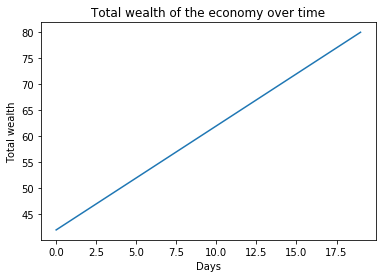

In [116]:
econ.plot_wealth()

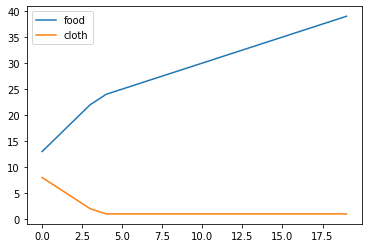

In [117]:
econ.plot_person(econ.farmer)

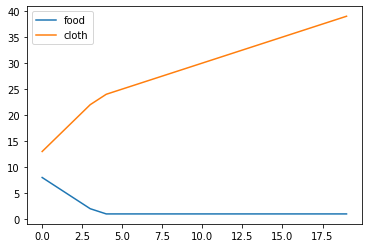

In [118]:
econ.plot_person(econ.carpenter)